In [3]:
import os
import pandas as pd
import math
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import gdal
import geopandas as gpd
import descartes 
from shapely.geometry import Point, Polygon
#os.chdir('../../')
os.getcwd()

'C:\\Users\\leogo\\OneDrive\\Desktop\\PhD\\Analysis'

# Loading RHoMIS and Adding GeoPandas Geometry #

In [4]:
rhomis_indicator=pd.read_csv(
    os.path.join("data", "rhomis_data","RHoMIS_Indicators.csv"), 
    encoding="latin1", 
    low_memory=False)

latitude_not_null=rhomis_indicator.loc[:,"GPS_LAT"].notnull()
longitude_not_null=rhomis_indicator.loc[:,"GPS_LON"].notnull()
spatially_explicit_rhomis=rhomis_indicator.loc[latitude_not_null&longitude_not_null,:]

columns_to_subset=["GPS_LAT", 
                   "GPS_LON", 
                   "total_income_USD_PPP_pHH_Yr"]

#subsetting RHoMIS
#spatially_explicit_rhomis=spatially_explicit_rhomis.loc[spatially_explicit_rhomis.loc[:,"ID_COUNTRY"]=="BF",:]
boolean_column_location=spatially_explicit_rhomis.columns.isin(columns_to_subset)
rhomis_variables=pd.DataFrame(spatially_explicit_rhomis.loc[:,boolean_column_location])

geometry=[Point(xy) for xy in zip(rhomis_variables["GPS_LON"], rhomis_variables["GPS_LAT"])]
crs={'init' :'epsg:4326'}
rhomis_variables = gpd.GeoDataFrame(rhomis_variables, geometry=geometry,crs=crs)

In [5]:
import re
shapefiles_in_folder=os.listdir(os.path.join("data", "shapefiles"))
regular_expression= re.compile(".*km")

#regex_shapefiles=[re.match(regular_expression, x) for x in shapefiles_in_folder]
#regex_shapefiles=[re.search(regular_expression, x) for x in shapefiles_in_folder]

regex_shapefiles=[]
for x in shapefiles_in_folder:
    temporary_matching=re.match(regular_expression, x)
    if temporary_matching is not None:
        regex_shapefiles.append(temporary_matching.group(0))
len(regex_shapefiles)

2

# Creating Spatial Grid over world shapefile #

In [6]:
world_shapefile=gpd.read_file(
    os.path.join('data', 'shapefiles', 'World'))


grid_size= 100000
#grid_size_km=grid_size/1000

def create_world_grid(world_shapefile, grid_size):
    radius_of_earth=6371000
    longitude_minimum, latitude_minimum, longitude_maximum, latitude_maximum=world_shapefile.total_bounds

    def append_polygons_list(polygons ,origin ,horizontal_step, vertical_step, horizontal_bound,vertical_bound):
        long_left=origin[0]
        lat_bottom=origin[1] 

        long_right=long_left+horizontal_step
        if abs(long_right)>abs(horizontal_bound):
            long_right=horizontal_bound

        lat_top=lat_bottom+vertical_step
        if abs(lat_top)>abs(vertical_bound):
            lat_top=vertical_bound

        polygons.append(Polygon([(long_left,lat_bottom),(long_left,lat_top),(long_right,lat_top),(long_right,lat_bottom)]))
        return polygons


    def update_origins(origin_south_west, origin_north_west, origin_north_east, origin_south_east, latitude_step, longitude_step):
        origin_south_west=[origin_south_west[0]-longitude_step,origin_south_west[1]-latitude_step]
        origin_north_west=[origin_north_west[0]-longitude_step,origin_north_west[1]+latitude_step]
        origin_north_east=[origin_north_east[0]+longitude_step,origin_north_east[1]+latitude_step]
        origin_south_east=[origin_south_east[0]+longitude_step,origin_south_east[1]-latitude_step]
        return origin_south_west, origin_north_west, origin_north_east, origin_south_east

    #initialising polygons list and setting coordinates to 0 lat 0 long
    polygons=[] 
    origin=[0,0] 
    origin_south_west=origin
    origin_north_west=origin
    origin_north_east=origin
    origin_south_east=origin


    latitude_limit=min([abs(latitude_minimum), abs(latitude_maximum)])
    longitude_limit=min([abs(longitude_minimum), abs(longitude_maximum)])

    # This is the increase in latitude required to produce grids of a particular size.
    latitude_step=(180*grid_size)/(math.pi*(radius_of_earth))
    sum_of_latitude_steps=0

    while sum_of_latitude_steps<latitude_limit:
        sum_of_longitude_steps=0    
        while sum_of_longitude_steps<180:
            # If we have a latitude of zero then our longitude step tends to infinity, must avoid this.
            if math.cos(math.radians(origin_north_west[1]))>0.01:
                # The change in longitude required to produce the particular grid size, this is important as it varies according to latitude
                longitude_step=(180*grid_size)/(math.pi*(radius_of_earth)*math.cos(math.radians(origin_north_west[1])))            
                sum_of_longitude_steps=sum_of_longitude_steps+longitude_step
                # north west movement
                polygons=append_polygons_list(polygons=polygons,
                                          origin=origin_north_west, 
                                          horizontal_step=-longitude_step,
                                          vertical_step=latitude_step,
                                          horizontal_bound=longitude_minimum,
                                         vertical_bound=latitude_maximum)
                # north east movement
                polygons=append_polygons_list(polygons=polygons,
                                          origin=origin_north_east, 
                                          horizontal_step=longitude_step,
                                          vertical_step=latitude_step,
                                          horizontal_bound=longitude_maximum,
                                         vertical_bound=latitude_maximum)

                # south west movement
                polygons=append_polygons_list(polygons=polygons,
                                          origin=origin_south_west, 
                                          horizontal_step=-longitude_step,
                                          vertical_step=-latitude_step,
                                          horizontal_bound=longitude_minimum,
                                         vertical_bound=latitude_minimum)

                # south east movement
                polygons=append_polygons_list(polygons=polygons,
                                          origin=origin_south_east, 
                                          horizontal_step=longitude_step,
                                          vertical_step=-latitude_step,
                                          horizontal_bound=longitude_maximum,
                                         vertical_bound=latitude_minimum)
                origin_south_west, origin_north_west, origin_north_east, origin_south_east=update_origins(origin_south_west, origin_north_west, origin_north_east, origin_south_east, latitude_step=0, longitude_step=longitude_step)

        origin_south_west, origin_north_west, origin_north_east, origin_south_east=update_origins(origin_south_west=[0,origin_south_west[1]], origin_north_west=[0,origin_north_west[1]], origin_north_east=[0,origin_north_east[1]], origin_south_east=[0,origin_south_east[1]], latitude_step=latitude_step, longitude_step=0)
        sum_of_latitude_steps=sum_of_latitude_steps+latitude_step



    grid = gpd.GeoDataFrame({'geometry':polygons})
    os.mkdir(os.path.join("data","shapefiles","world_grid_"+str(grid_size/1000)+"km"))
    grid.to_file(os.path.join("data","shapefiles","world_grid_"+str(grid_size/1000)+"km","grid.shp"))
    
#create_world_grid(world_shapefile, grid_size)

In [7]:
world_grid=gpd.read_file(os.path.join("data","shapefiles","world_grid_"+str(grid_size/1000)+"km","grid.shp"))
world_grid=gpd.GeoDataFrame(world_grid,crs={'init' :'epsg:4326'})

In [8]:
country="All"
if country!="All":
    boundary_for_country=world_shapefile.loc[world_shapefile.loc[:,'CNTRY_NAME']==country,:].boundary
    total_bounds_for_country=world_shapefile.loc[world_shapefile.loc[:,'CNTRY_NAME']==country,:].total_bounds
    country_geo_dataframe=world_shapefile.loc[world_shapefile.loc[:,'CNTRY_NAME']==country,:]
    
    country_grid=gpd.sjoin(world_grid,country_geo_dataframe,how="inner")
if country=="All":
    boundary_for_country=world_shapefile.boundary
    total_bounds_for_country=world_shapefile.total_bounds
    country_grid=gpd.overlay(world_grid,world_shapefile,how="intersection")

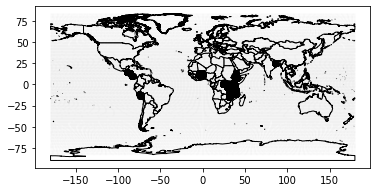

In [9]:
figure, ax= plt.subplots()
world_shapefile.plot(ax=ax, color="white", edgecolor="black")
world_grid.boundary.plot(ax=ax, color=None, edgecolor="black", linewidth=0.01)
rhomis_variables.plot(ax=ax, color="black", linewidth=0.01)
plt.show()

In [10]:
intersected_grid_points=gpd.sjoin(rhomis_variables,world_grid,'left') #creating a grid of points within all of the world grid points
# The geometry in this case is the geometry of the 'points' of RHoMIS data
minimum_number_of_households_in_a_square=intersected_grid_points.loc[:,"FID"].value_counts().min()
maximum_number_of_households_in_a_square=intersected_grid_points.loc[:,"FID"].value_counts().max()


In [11]:
#pd.isna(intersected_grid_country.loc[:,"CNTRY_NAME"])==False
#pd.unique(intersected_grid_country.loc[:,"CNTRY_NAME"])
intersected_grid_country=gpd.sjoin(world_grid, world_shapefile, "left")
intersected_grid_country=intersected_grid_country.loc[pd.isna(intersected_grid_country.loc[:,"CNTRY_NAME"])==False,:]
intersected_grid_country.head()

intersected_grid_country=pd.merge(intersected_grid_country, world_shapefile, 
         left_on="CNTRY_NAME", right_on="CNTRY_NAME",
        suffixes=["_Grid_Level","_Country_Level"])
intersected_grid_country.head()


all_intersected=pd.merge(intersected_grid_points,intersected_grid_country,
                         left_on="FID", right_on="FID",
                        suffixes=["_Point_Level",""])


all_intersected=all_intersected.drop(["index_right_Point_Level"],axis=1)

all_intersected=all_intersected.drop(["OBJECTID_Grid_Level"],axis=1)
all_intersected=all_intersected.drop(["index_right"],axis=1)
all_intersected=all_intersected.drop(["GPS_LAT"],axis=1)
all_intersected=all_intersected.drop(["GPS_LON"],axis=1)

all_intersected=all_intersected.rename({"geometry":"geometry_Point_Level"})
all_intersected=all_intersected.rename({"FID":"Grid_ID"})


all_intersected.head()

#all_intersected.columns = all_intersected.columns.str.replace("index_right", "_")
#all_intersected.head()

,total_income_USD_PPP_pHH_Yr,geometry,FID,geometry_Grid_Level,CNTRY_NAME,OBJECTID_Country_Level,geometry_Country_Level
0,99.643879,POINT (-89.31000 14.72000),13104,"POLYGON ((-89.13089 14.38915, -90.05933 14.389...",Honduras,99,"MULTIPOLYGON (((-86.62668 16.27028, -86.63390 ..."
1,99.643879,POINT (-89.31000 14.72000),13104,"POLYGON ((-89.13089 14.38915, -90.05933 14.389...",El Salvador,67,"POLYGON ((-89.95445 13.66398, -90.00000 13.697..."
2,99.643879,POINT (-89.31000 14.72000),13104,"POLYGON ((-89.13089 14.38915, -90.05933 14.389...",Guatemala,93,"POLYGON ((-92.16446 14.48389, -92.21890 14.521..."
3,4744.946629,POINT (-89.30000 14.72000),13104,"POLYGON ((-89.13089 14.38915, -90.05933 14.389...",Honduras,99,"MULTIPOLYGON (((-86.62668 16.27028, -86.63390 ..."
4,4744.946629,POINT (-89.30000 14.72000),13104,"POLYGON ((-89.13089 14.38915, -90.05933 14.389...",El Salvador,67,"POLYGON ((-89.95445 13.66398, -90.00000 13.697..."


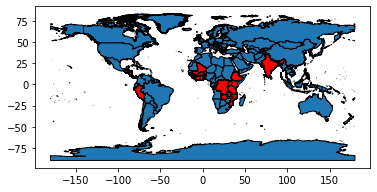

In [12]:
fig, ax = plt.subplots(1,1)

world_shapefile.plot(ax=ax,color=None, edgecolor="black")
all_intersected.set_geometry("geometry_Country_Level").plot(ax=ax, color="red",edgecolor="black")

#columns_to_drop=["index_right","OBJECT_ID_Grid_Level"]
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

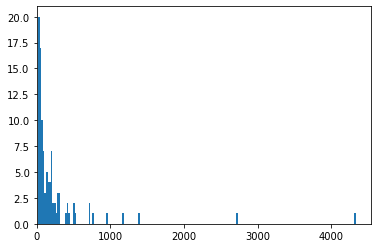

In [26]:
all_intersected.columns
grids_with_particular_counts=all_intersected.loc[:,"FID"].value_counts()
grids_with_particular_counts=grids_with_particular_counts[grids_with_particular_counts>20]
fig, ax= plt.subplots()

plt.hist(grids_with_particular_counts, bins=200)
plt.xlim( xmin=0)
plt.show